  ranked_id         hap       fit model  N_max       r/s
0      H000  1001100011  1.000000    nk      4  1.171044
1      H001  0001100011  0.984447    nk      4  1.171044
2      H002  1001100111  0.961883    nk      4  1.171044
3      H003  0001100111  0.946330    nk      4  1.171044
4      H004  1001111011  0.929235    nk      4  1.171044


<Figure size 432x288 with 0 Axes>

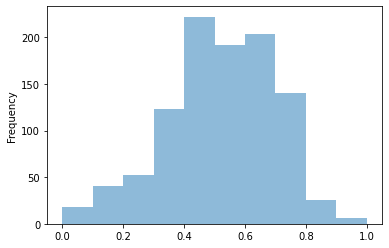

In [1]:
#construct 4-bit landscape
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# read input & collect all info into a dictionary
file = '../data/nk-landscape.tsv' # 10-bit landscape
df = pd.read_csv(file, delimiter="\t", dtype={'hap':str}) # hap column as strings (otherwise read as numbers)
print(df.head())
plt.figure()
#df['fit'].plot.hist(bins=10)
recs = df.to_dict("records")
dHap = {}
for rec in recs:
    dHap[rec['hap']] = {'id': rec['ranked_id'], 'fit': rec['fit']}
#print(dHap)
plt.figure();
df['fit'].plot.hist(alpha=0.5);

In [2]:
# build graph, add nodes & attach fitness as features
DG = nx.DiGraph() 
for hap in dHap: # hap as key
    DG.add_node(hap)
    for k in dHap[hap]: # k includes 'id' and 'fit'
        DG.nodes[hap][k] = dHap[hap][k]
    DG.nodes[hap]['alpha'] = dHap[hap]['fit'] # assign fitness as alpha (transparency)
#print(DG.nodes)

In [7]:
# Test case: add edges recursively
# The total number of unique binary haps of length n is the sum of binomial coefficients
# which evaluates to 2^n (https://mathworld.wolfram.com/BinomialSums.html)
# The total number of 1-bit edges is: n2^2 - n*2^(n-1) = n* 2^(n-1)
def add_edge_test(G, hap, outList, k, seen):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        nabes = {'level':k, 'hap_list': []} # start a list
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                nabes['hap_list'].append(mut)
        outList.append(nabes) # append hap list to output list
        k += 1 # next level
        for x in nabes['hap_list']: # recurse on each child node
            if x not in seen: # skip if seen
                add_edge_test(G, x, outList, k, seen)

out = []
seen_nodes = {}
add_edge_test(DG, '00000', out, 1, seen_nodes) # start recursion at '0000'
levels = np.unique(np.array([x['level'] for x in out]))
for lev in levels:
    flat = []
    hap = [x['hap_list'] for x in out if x['level'] == lev]
    for h in hap:
        flat.append(h)
    print(lev, ":", np.unique(np.array(flat)))
#print(out)
#for x in out:
#    print(x)   

1 : ['00001' '00010' '00100' '01000' '10000']
2 : ['00011' '00101' '00110' '01001' '01010' '01100' '10001' '10010' '10100'
 '11000']
3 : ['00111' '01011' '01101' '01110' '10011' '10101' '10110' '11001' '11010'
 '11100']
4 : ['01111' '10111' '11011' '11101' '11110']
5 : ['11111']


In [3]:
# now add edges & assign layers
# layout and draw Gallary:https://networkx.org/documentation/stable/auto_examples/index.html
def add_fit_edge(G, hap, seen, level):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        G.nodes[hap]['subset'] = level # networkx uses node feature 'subset' to store levels for multipartite layout
        nabes = [] # start a list of 1-hamming neighbors
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                if G.nodes[hap]['fit'] > G.nodes[mut]['fit']:
                    G.add_edge(mut, hap)
                else:
                    G.add_edge(hap, mut)
                nabes.append(mut)
        level += 1
        for x in nabes: # recurse on each child node
            if x not in seen: # skip if seen
                G.nodes[x]['subset'] = level
                add_fit_edge(G, x, seen, level)
seen_nodes = {}
add_fit_edge(DG, '0000000000', seen_nodes, 0) # start point
#print(DG.nodes())
#print(len(DG.edges()))

# node coloring by fitness 
#node_colors = range(10)
node_alphas = [ DG.nodes[x]['fit'] for x in DG.nodes]
#print(node_alphas)

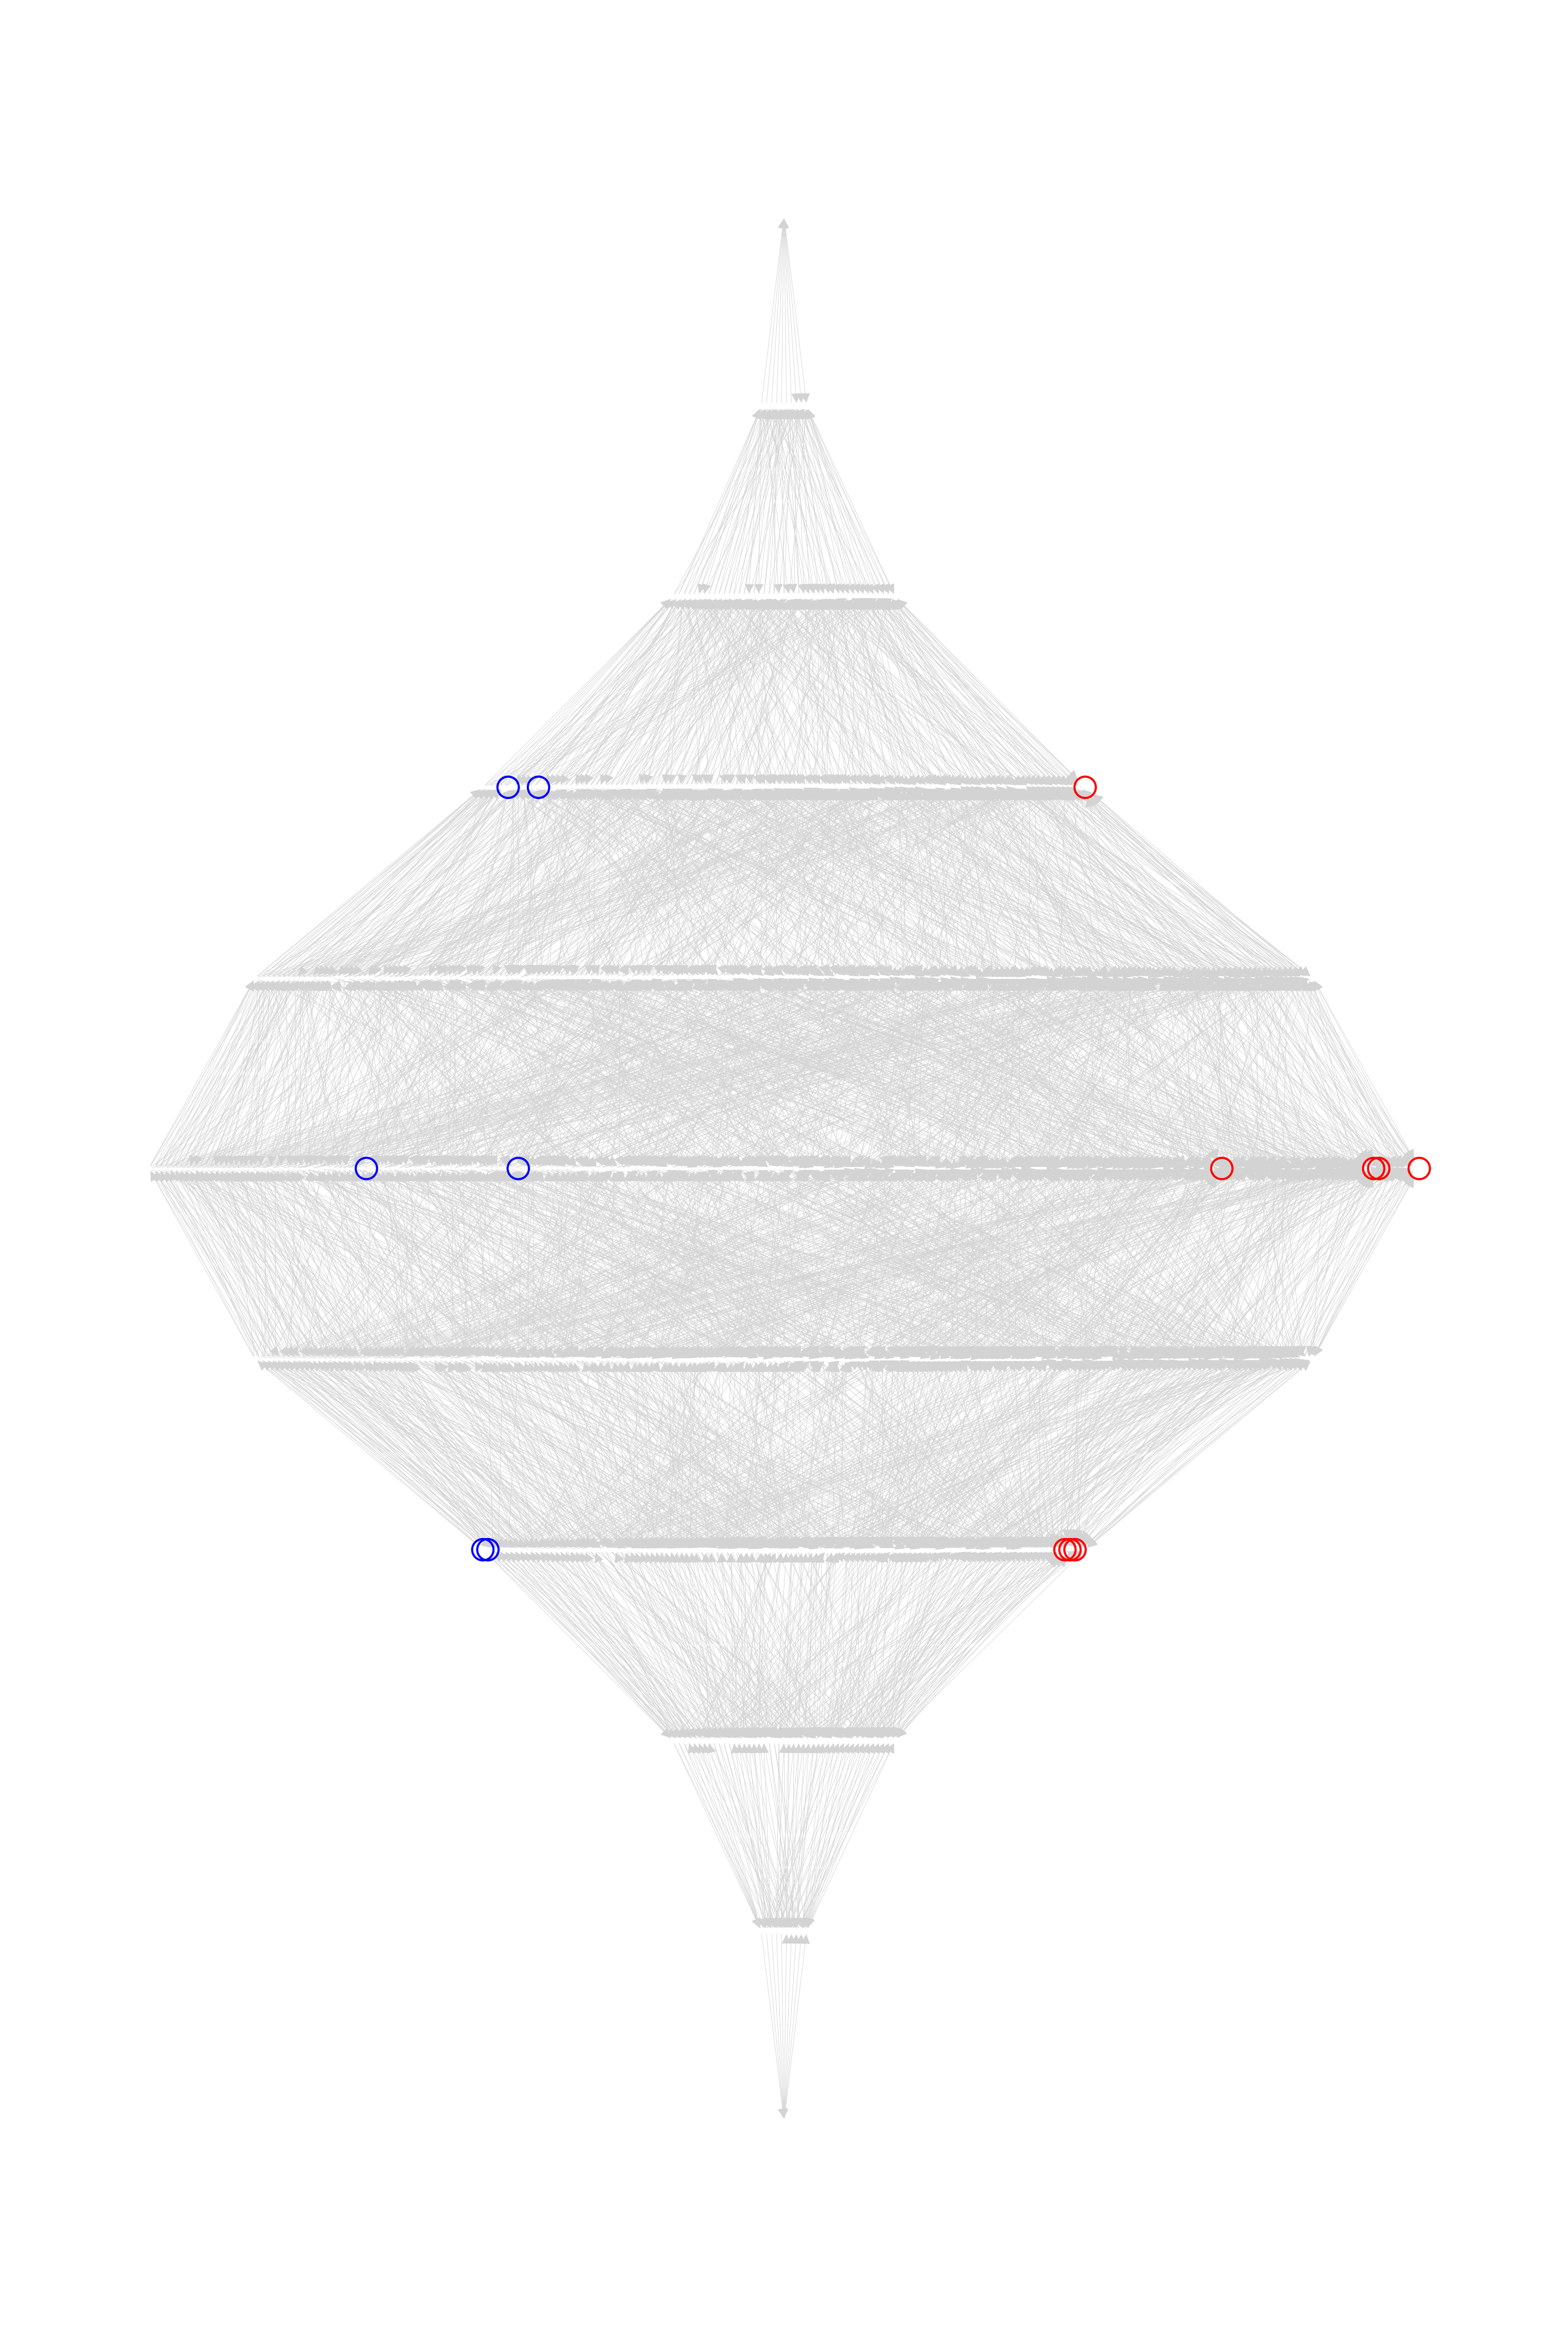

<Figure size 432x288 with 0 Axes>

In [236]:
# multi-partite layout, subset by num of 0's
#ndColors = [  "orange" if x[1] == 0 else "white" for x in DG.out_degree() ]
ndColors = []
ndSizes = []
for x in DG.out_degree():
    if x[1] == 0:
        ndColors.append("red")
        ndSizes.append(100)
    elif x[1] == 10:
        ndColors.append("blue")
        ndSizes.append(100)
    else:
        ndColors.append("none")
        ndSizes.append(10)
    
#ndSizes = [  50 if x[1] == 0 else 10 for x in DG.out_degree() ]
pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (10,15), dpi=300)
nx.draw(DG, pos = pos,
        node_size = ndSizes,
        edge_color = "lightgray",
        edgecolors = ndColors,
        node_color = "none",
        width = 0.2
       )
plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])

1001100011
['1011100011', '0001100011', '1000100011', '1001101011', '1001110011', '1001000011', '1001100011', '1001100010', '1001100111', '1001100001', '1101100011']


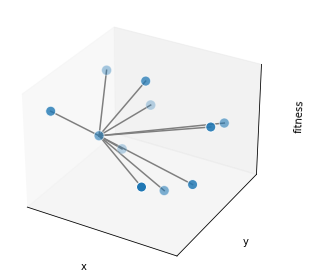

            hap  in_deg  out_deg       fit    id
0    1001100011      10        0  1.000000  H000
4    1001111011      10        0  0.929235  H004
33   1110011000      10        0  0.793799  H033
35   1010111000      10        0  0.788717  H035
51   1110000000      10        0  0.772744  H051
55   1101000000      10        0  0.770628  H055
59   1010100000      10        0  0.767662  H059
172  1101011000      10        0  0.699863  H172
             hap  in_deg  out_deg       fit     id
746   0011010101       0       10  0.419580   H746
849   0111110101       0       10  0.363240   H849
871   0011001101       0       10  0.343966   H871
921   0111101101       0       10  0.287626   H921
1022  0000001110       0       10  0.016205  H1022
1023  0000010110       0       10  0.000000  H1023


In [237]:
# degree analysis: fitness peak has only in_degrees and no out_degrees
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
#print(DG.in_degree()) # in-degree
#print(DG.out_degree()) # in-degree
in_deg = [x[1] for x in DG.in_degree()]
out_deg = [x[1] for x in DG.out_degree()]
haps = [x[0] for x in DG.in_degree()]
fits = [DG.nodes[x]['fit'] for x in DG.nodes]
ids = [DG.nodes[x]['id'] for x in DG.nodes]
#print(in_deg)
#print(out_deg)
#print(haps)
dfDeg = pd.DataFrame({'hap': haps, 'in_deg': in_deg, 'out_deg':out_deg, 'fit':fits, 'id': ids} )
#print(dfDeg.head())

###################
# plot subgraph with 3D 
peaks = dfDeg[dfDeg['out_deg'] == 0] # local and global peaks
vals = dfDeg[dfDeg['in_deg'] == 0] # fitness valleys
#dfDeg.plot.bar(x = 'hap', stacked = True)
#dfDeg.plot.bar(x = 'hap', subplots = True)

peakHap = peaks['hap'].tolist()[0]
valHap = vals['hap'].tolist()[-1]
peakG = nx.ego_graph(DG, peakHap, radius=1, center=True, undirected=True, distance=None)
valG = nx.ego_graph(DG, valHap, radius=1, center=True, undirected=True, distance=None)
print(peakHap)
print(peakG.nodes())

# spring layout
pos = nx.spring_layout(peakG, dim=3, seed=779)
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(peakG)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in peakG.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("fitness")


_format_axes(ax)
fig.tight_layout()
plt.show()

print(peaks)
print(vals)

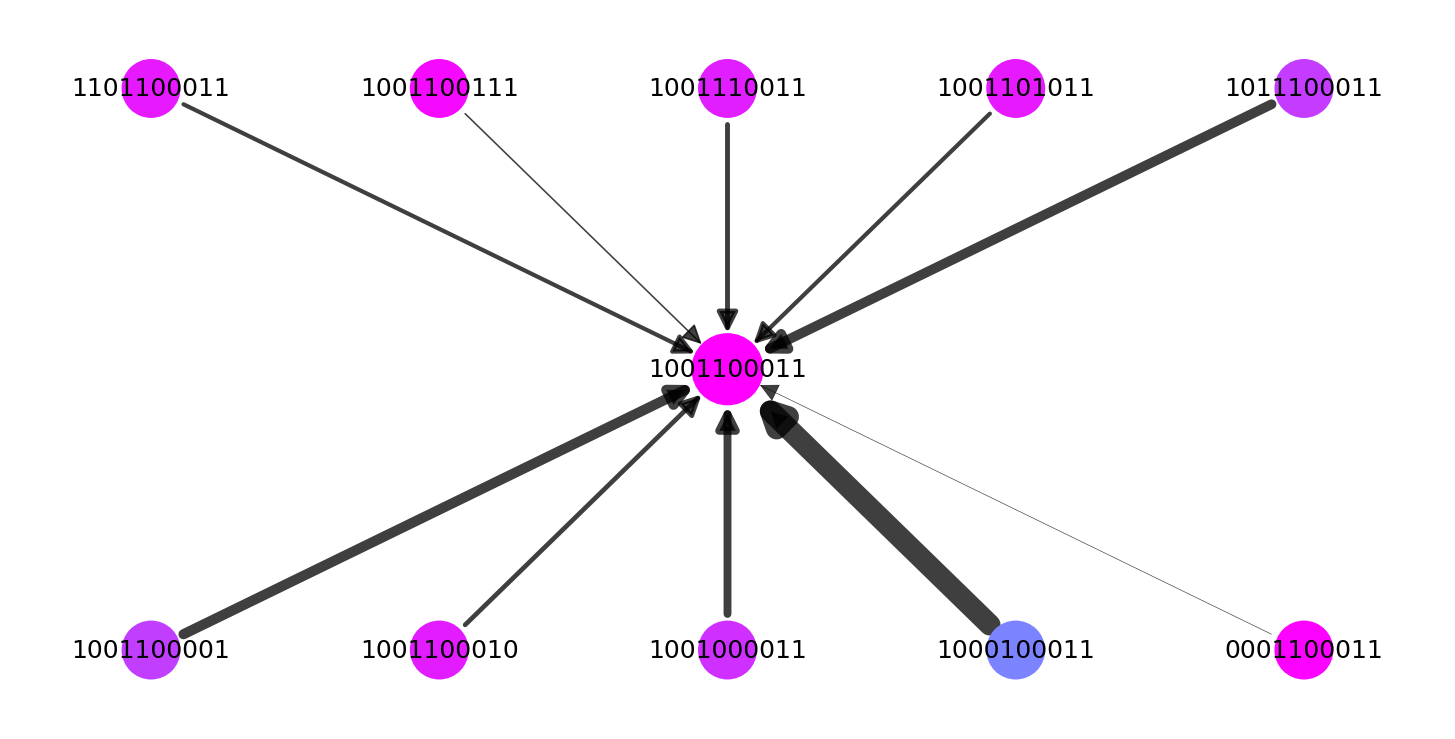

<Figure size 432x288 with 0 Axes>

In [230]:
# Draw graph
#pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
#nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

#from itertools import count
#groups = set(nx.get_node_attributes(peakG,'fit').values())
#print(groups)
#mapping = dict(zip(sorted(groups),count()))
#print(mapping)
#nodes = peakG.nodes()
#colors = [mapping[peakG.nodes[n]['fit']] for n in nodes]

#M = peakG.number_of_nodes()
#node_alphas = [(5 + i) / (M + 4) for i in range(M)]
#node_colors = range(0, 1)
#node_alphas = set(nx.get_node_attributes(peakG,'fit').values())
#node_colors = range(nx.get_node_attributes(peakG,'fit').values())
#cmap = plt.cm.plasma
# drawing nodes and edges separately so we can capture collection for colobar
#pos = nx.spring_layout(g)
#plt.show()

# Draw ego as large and red
#import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

peakFits = [peakG.nodes[x]['fit'] for x in peakG.nodes]
#print(peakFits)
#fmin = min(peakFits)
#fmax = max(peakFits)
#print(fmin, fmax)

#fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
#fig = plt.subplots(1, figsize=(7, 3))
#for ax in axs.flat:
#    im = ax.pcolormesh(arr, **pc_kwargs)
#fig.colorbar(im, ax=axs, shrink=0.6)
#fig, ax = plt.subplots(figsize=(7, 1))
#fig.subplots_adjust(top=0.5)
#plt.colorbar(nc)

# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
peakNodeColors = [ mapper.to_rgba(v) for v in peakFits  ]
#peakLabels = peakG.nodes()
#print(peakNodeColors)

# highlight center
peakNodeSizes = [ 300 if x == peakHap  else 200 for x in peakG.nodes ]
peakNodeEdges = [ "black" if x == peakHap  else "none" for x in peakG.nodes ]
peakEdgeWidth = [ abs(peakG.nodes[x[0]]['fit']-peakG.nodes[x[1]]['fit'])*10 for x in peakG.edges()]

# plot nodes and edges seprately
pos = nx.multipartite_layout(peakG, align = 'horizontal')
#print(pos)
plt.figure(figsize = (6,3), dpi=300)
ec = nx.draw_networkx_edges(peakG, pos, alpha=0.75, width=peakEdgeWidth)
nc = nx.draw_networkx_nodes(peakG, pos, 
                            node_color=peakNodeColors, 
                            node_size=peakNodeSizes, 
                            edgecolors=peakNodeEdge
                            )
nl = nx.draw_networkx_labels(peakG, pos, font_size =6)
#pc = mpl.collections.PatchCollection(nc, cmap=cmap)
#ax = plt.gca()
#ax.set_axis_off()
#plt.colorbar(pc, label='Fitness')

plt.axis('off')
plt.show()
plt.savefig("peak.png")

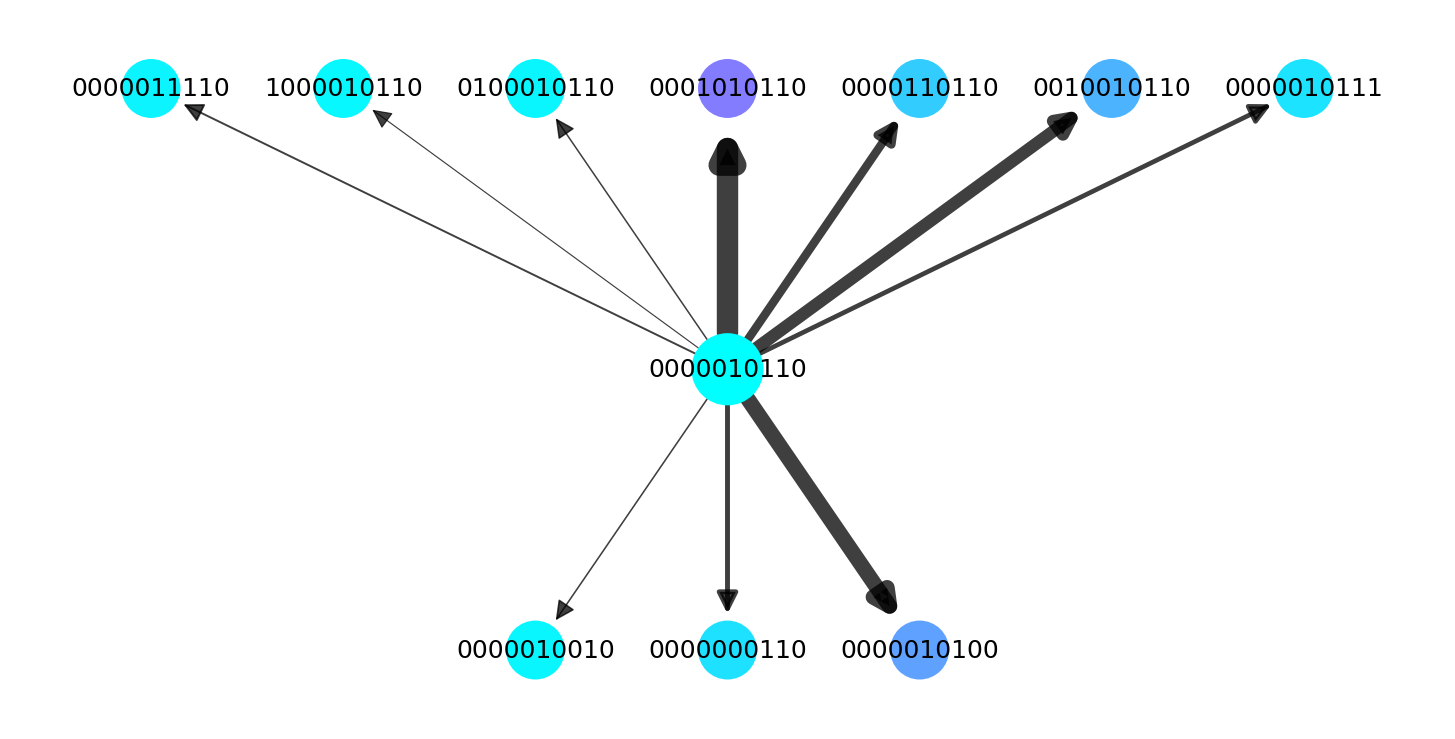

<Figure size 432x288 with 0 Axes>

In [231]:
valFits = [valG.nodes[x]['fit'] for x in valG.nodes]
# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
valNodeColors = [ mapper.to_rgba(v) for v in valFits  ]
#print(peakNodeColors)

# highlight center
valNodeSizes = [ 300 if x == valHap  else 200 for x in valG.nodes ]
valNodeEdges = [ "black" if x == peakHap  else "none" for x in valG.nodes ]
valEdgeWidth = [ abs(valG.nodes[x[0]]['fit']-valG.nodes[x[1]]['fit'])*10 for x in valG.edges()]

# plot nodes and edges seprately
pos = nx.multipartite_layout(valG, align = 'horizontal')
plt.figure(figsize = (6,3), dpi=300)
ec = nx.draw_networkx_edges(valG, pos, alpha=0.75, width=valEdgeWidth)
nc = nx.draw_networkx_nodes(valG, pos,  
                            node_color=valNodeColors, 
                            node_size=valNodeSizes, 
                            edgecolors=valNodeEdges
                            )
nl = nx.draw_networkx_labels(valG, pos, font_size = 6)
#pc = mpl.collections.PatchCollection(nc, cmap=cmap)
#ax = plt.gca()
#ax.set_axis_off()
#plt.colorbar(pc, label='Fitness')

plt.axis('off')
plt.show()
plt.savefig("valley.png")

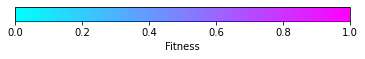

In [233]:
fig, ax = plt.subplots(figsize=(6, 0.5))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Fitness')